# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

/var/folders/n0/v391ctcn3q935by3r0yv_bb80000gn/T/ipykernel_84057/3200777626.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the data
def load_data():
    dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
    df_train = pd.read_csv("train.csv", parse_dates=['Date'], date_parser=dateparse)
    df_test = pd.read_csv("test.csv", parse_dates=['Date'], date_parser=dateparse)
    df_store = pd.read_csv("store.csv")
    return df_train, df_test, df_store

df_train, df_test, df_store = load_data()

# Data Overview
print(df_train.info())
print(df_store.info())

# Missing Value Analysis
print(df_train.isnull().sum())
print(df_store.isnull().sum())

/var/folders/n0/v391ctcn3q935by3r0yv_bb80000gn/T/ipykernel_84057/3636117461.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_train = pd.read_csv("train.csv", parse_dates=['Date'], date_parser=dateparse)
/var/folders/n0/v391ctcn3q935by3r0yv_bb80000gn/T/ipykernel_84057/3636117461.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("train.csv", parse_dates=['Date'], date_parser=dateparse)
/var/folders/n0/v391ctcn3q935by3r0yv_bb80000gn/T/ipykernel_84057/3636117461.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_test = pd.read_csv("test.csv", parse_dates=['Date'], date_parser=dateparse)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store 

In [3]:
# Data Cleaning
def clean_data(df_train, df_store):
    # Handle missing values
    df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace=True)
    df_store['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
    df_store['CompetitionOpenSinceYear'].fillna(0, inplace=True)
    df_store['Promo2SinceWeek'].fillna(0, inplace=True)
    df_store['Promo2SinceYear'].fillna(0, inplace=True)
    df_store['PromoInterval'].fillna('0', inplace=True)
    
    # Remove outliers and invalid data points
    df_train = df_train[(df_train['Open'] != 0) & (df_train['Sales'] > 0)].copy()
    
    # Merge datasets
    df = pd.merge(df_train, df_store, how='left', on='Store')
    
    return df

cleaned_data = clean_data(df_train, df_store)

/var/folders/n0/v391ctcn3q935by3r0yv_bb80000gn/T/ipykernel_84057/2065312130.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace=True)
/var/folders/n0/v391ctcn3q935by3r0yv_bb80000gn/T/ipykernel_84057/2065312130.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedi

## EDA

### 1. Store Performance Analysis

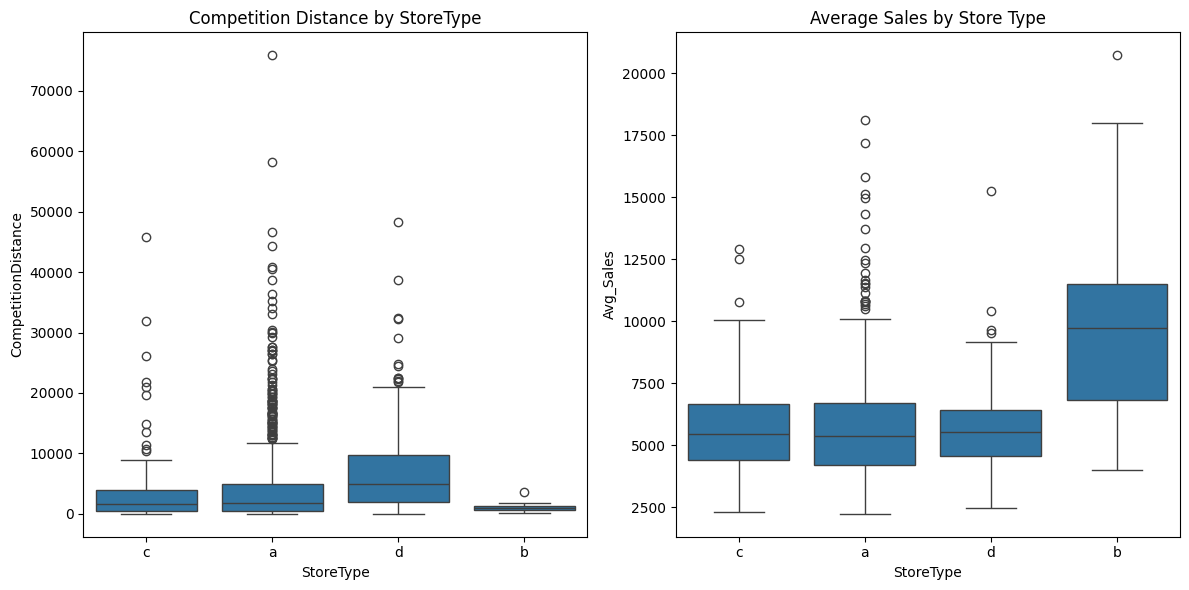

In [4]:
# 1. Store Performance Analysis
def analyze_store_performance(df_train, df_store):
    # Plot CompetitionDistance by StoreType
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='StoreType', y='CompetitionDistance', data=df_store)
    plt.title('Competition Distance by StoreType')
    
    # Analyze store performance
    store_perf = df_train.groupby('Store').agg({
        'Sales': ['mean', 'sum'],
        'Customers': ['mean', 'sum']
    })
    store_perf.columns = ['Avg_Sales', 'Total_Sales', 'Avg_Customers', 'Total_Customers']
    store_perf = store_perf.join(df_store.set_index('Store')[['StoreType', 'CompetitionDistance']])
    
    # Plot Avg_Sales by StoreType
    plt.subplot(1, 2, 2)
    sns.boxplot(x='StoreType', y='Avg_Sales', data=store_perf.reset_index())
    plt.title('Average Sales by Store Type')
    
    plt.tight_layout()
    plt.show()
    
    return store_perf

# Assuming df_train and df_store are already defined
store_performance = analyze_store_performance(df_train, df_store)

### 2. Temporal Patterns Analysis

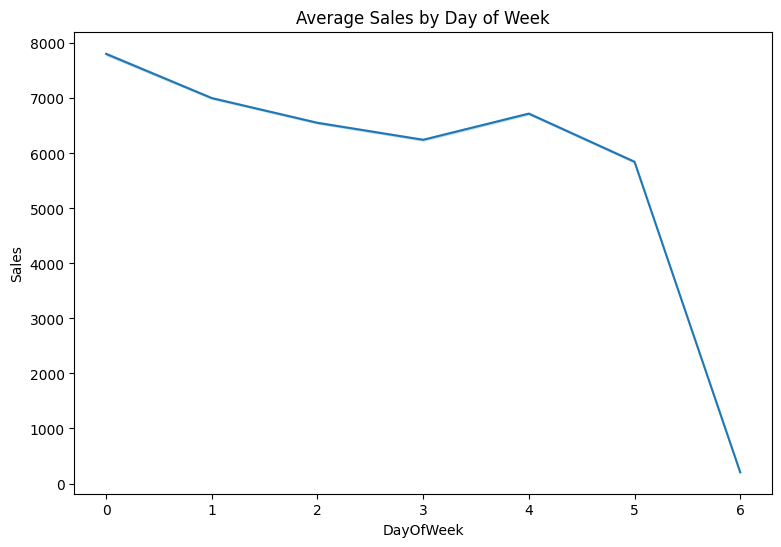

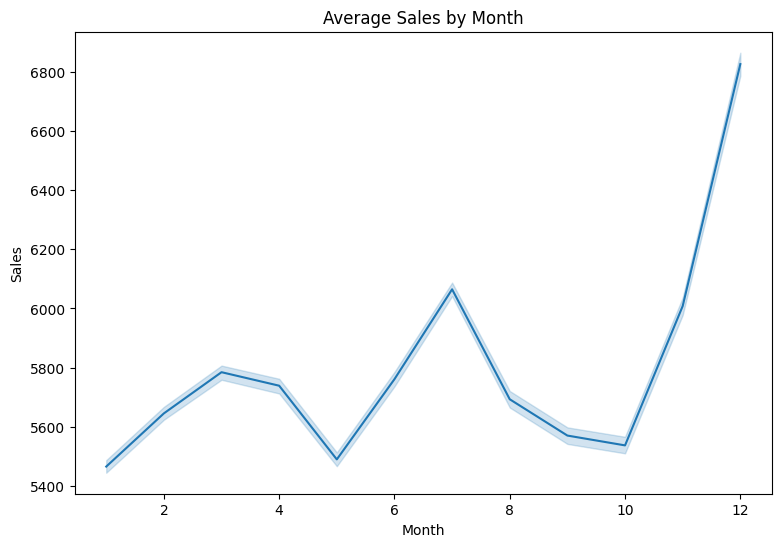

In [5]:
# 2. Temporal Patterns Analysis
def analyze_temporal_patterns(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['DayOfWeek'] = df.Date.dt.dayofweek
    
    plt.figure(figsize=(9, 6))
    sns.lineplot(x='DayOfWeek', y='Sales', data=df)
    plt.title('Average Sales by Day of Week')
    plt.show()
    
    plt.figure(figsize=(9, 6))
    sns.lineplot(x='Month', y='Sales', data=df)
    plt.title('Average Sales by Month')
    plt.show()

analyze_temporal_patterns(df_train)

### 3. Promotion Impact Analysis

Average sales increase during promotions: 81.37%


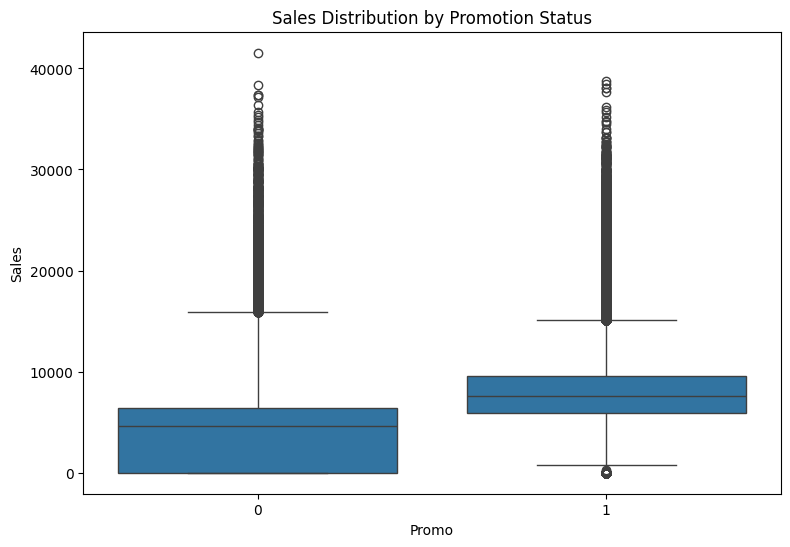

In [6]:
# 3. Promotion Impact Analysis
def analyze_promotion_impact(df):
    promo_impact = df.groupby('Promo')['Sales'].mean()
    promo_impact_pct = (promo_impact[1] - promo_impact[0]) / promo_impact[0] * 100
    
    print(f"Average sales increase during promotions: {promo_impact_pct:.2f}%")
    
    plt.figure(figsize=(9, 6))
    sns.boxplot(x='Promo', y='Sales', data=df)
    plt.title('Sales Distribution by Promotion Status')
    plt.show()

analyze_promotion_impact(df_train)

### 4. Competition Effects Analysis

Stores with nearby competitors have -6.79% lower average sales


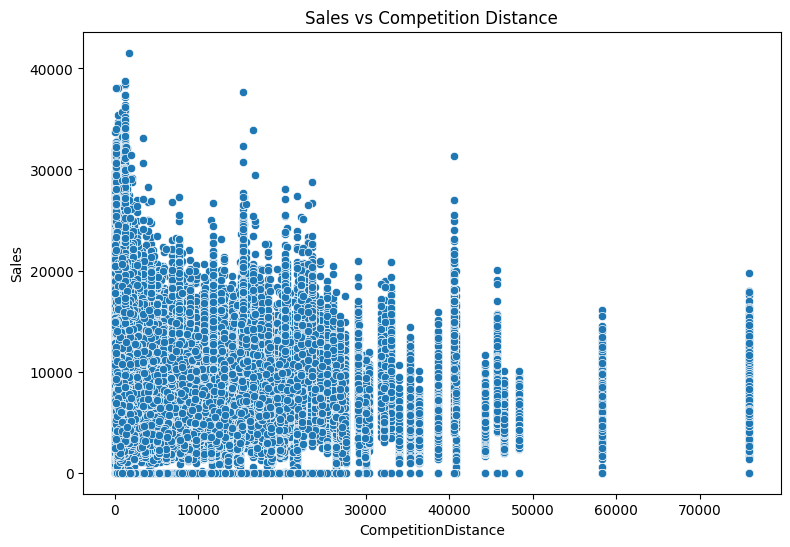

In [7]:
# 4. Competition Effects Analysis
def analyze_competition_effects(df_train, df_store):
    df = pd.merge(df_train, df_store[['Store', 'CompetitionDistance']], on='Store')
    df['NearCompetitor'] = df['CompetitionDistance'] <= 1000
    
    near_comp_sales = df[df['NearCompetitor']]['Sales'].mean()
    far_comp_sales = df[~df['NearCompetitor']]['Sales'].mean()
    sales_diff_pct = (far_comp_sales - near_comp_sales) / near_comp_sales * 100
    
    print(f"Stores with nearby competitors have {sales_diff_pct:.2f}% lower average sales")
    
    plt.figure(figsize=(9, 6))
    sns.scatterplot(x='CompetitionDistance', y='Sales', data=df)
    plt.title('Sales vs Competition Distance')
    plt.show()

analyze_competition_effects(df_train, df_store)

### 5. Analyze the interaction between store types and promotions

Promo                0             1   Increase
StoreType                                      
a          4300.418175   8068.080939  87.611544
b          9409.434791  11109.739497  18.070211
c          4435.040156   7810.174738  76.101556
d          4326.661817   7776.593414  79.736567


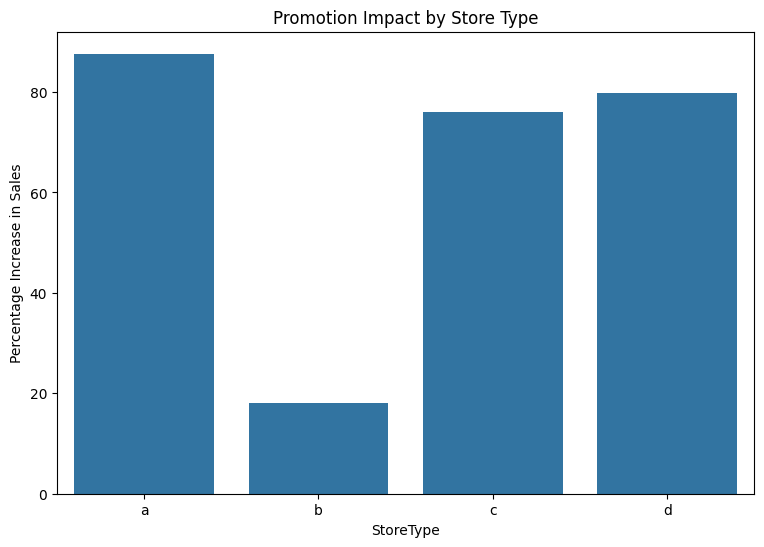

In [8]:
# 5. Analyze the interaction between store types and promotions
def analyze_store_promo_interaction(df_train, df_store):
    df = pd.merge(df_train, df_store, on='Store')
    promotion_impact = df.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack()
    promotion_impact['Increase'] = (promotion_impact[1] - promotion_impact[0]) / promotion_impact[0] * 100
    print(promotion_impact)

    plt.figure(figsize=(9, 6))
    sns.barplot(x=promotion_impact.index, y=promotion_impact['Increase'])
    plt.title('Promotion Impact by Store Type')
    plt.ylabel('Percentage Increase in Sales')
    plt.show()

analyze_store_promo_interaction(df_train, df_store)

### 6. Examine sales patterns during holidays

StateHoliday
0    5733.530624
0    5980.279717
a     290.735686
b     214.311510
c     168.733171
Name: Sales, dtype: float64


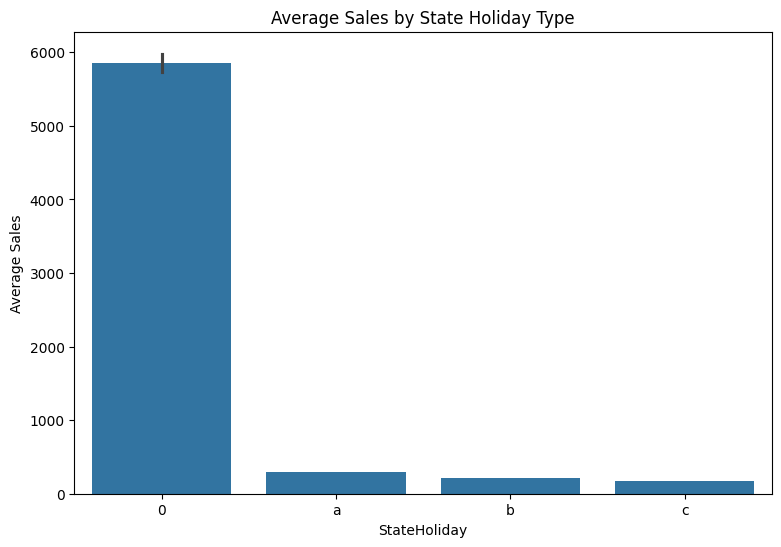

In [9]:
# 6. Examine sales patterns during holidays
def analyze_holiday_sales(df_train, df_store):
    df = pd.merge(df_train, df_store, on='Store')
    holiday_sales = df.groupby('StateHoliday')['Sales'].mean()
    print(holiday_sales)

    plt.figure(figsize=(9, 6))
    sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
    plt.title('Average Sales by State Holiday Type')
    plt.ylabel('Average Sales')
    plt.show()

analyze_holiday_sales(df_train, df_store)

### 7. Investigate the relationship between customer numbers and sales

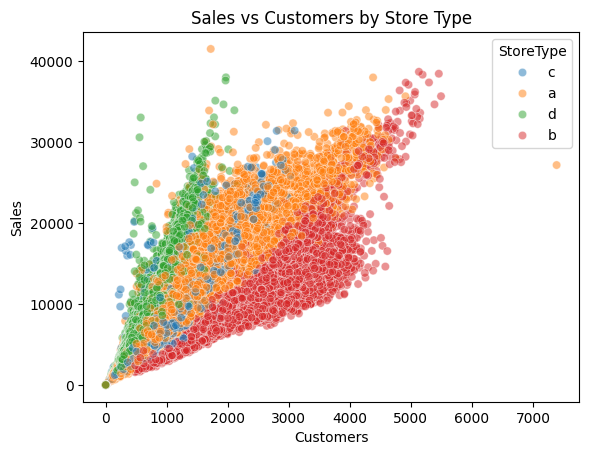

<Figure size 900x600 with 0 Axes>

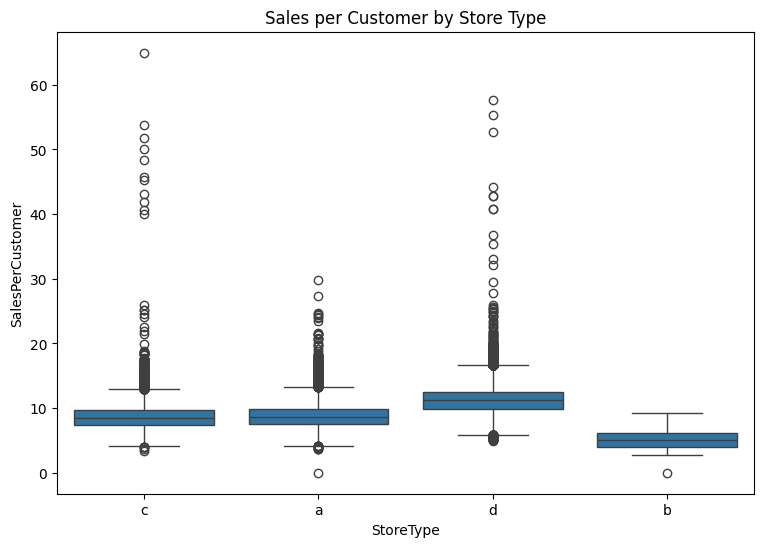

In [10]:
# 7. Investigate the relationship between customer numbers and sales
def analyze_customer_sales_relationship(df_train, df_store):
    df = pd.merge(df_train, df_store, on='Store')
    sns.scatterplot(data=df, x='Customers', y='Sales', hue='StoreType', alpha=0.5)
    plt.title('Sales vs Customers by Store Type')
    plt.figure(figsize=(9, 6))
    plt.show()

    df['SalesPerCustomer'] = df['Sales'] / df['Customers']
    plt.figure(figsize=(9, 6))
    sns.boxplot(data=df, x='StoreType', y='SalesPerCustomer')
    plt.title('Sales per Customer by Store Type')
    plt.show()

analyze_customer_sales_relationship(df_train, df_store)

### 8. Analyze the impact of competition over time

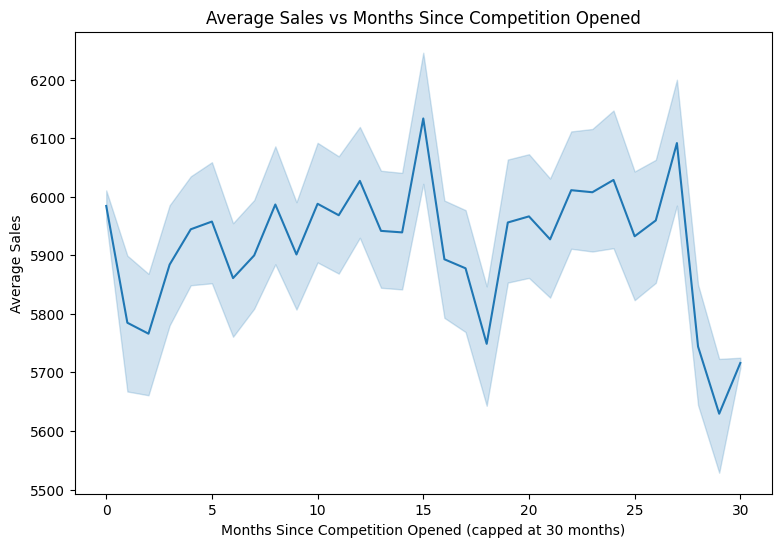

In [11]:
# 8. Analyze the impact of competition over time
def analyze_competition_impact(df_train, df_store):
    df = pd.merge(df_train, df_store, on='Store')
    
    # Calculate CompetitionOpen in months
    df['CompetitionOpen'] = 12 * (df['Date'].dt.year - df['CompetitionOpenSinceYear']) + \
                            (df['Date'].dt.month - df['CompetitionOpenSinceMonth'])
    
    # Set negative values to 0 (competition not yet opened)
    df['CompetitionOpen'] = df['CompetitionOpen'].clip(lower=0)
    
    # Cap at 24 months for visualization purposes
    df['CompetitionOpenMonths'] = df['CompetitionOpen'].clip(upper=30)

    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x='CompetitionOpenMonths', y='Sales')
    plt.title('Average Sales vs Months Since Competition Opened')
    plt.xlabel('Months Since Competition Opened (capped at 30 months)')
    plt.ylabel('Average Sales')
    plt.show()

analyze_competition_impact(df_train, df_store)

That's all. Thank you for your time to read my analysis and please feel free to give any comments.